In [1]:
using FITSIO, PyPlot, Interpolations, Optim
#using ForwardDiff: jacobiak1n3

# load 3D grid

In [2]:
grid = FITS(read ∘ first, "grid_files/am03cm10np05vp12.fits");
wls = (10 .^ range(log10(15100.802); step=6e-6, length=size(grid, 1)))

@assert all(isnan.(grid), dims=[2, 3, 4]) == any(isnan.(grid), dims=[2, 3, 4])
mask = .! any(isnan.(grid), dims=[2, 3, 4])[:]

grid = grid[mask, :, :, :];
wls = wls[mask]
;

In [3]:
param_names = ["teff", "logg", "metallicity"]
llimits = [3500., 0., -2.5]
steps   = [250, 0.5, 0.25]
ulimits = [6250, 5.0, 1.25]
ranges = (:).(llimits, steps, ulimits .- steps)

3-element Array{StepRangeLen{Float64,Base.TwicePrecision{Float64},Base.TwicePrecision{Float64}},1}:
 3500.0:250.0:6000.0
 0.0:0.5:4.5
 -2.5:0.25:1.0

-----
# Interpolation

## Naive multi-interpolation (separate interpolator for each pixel)
how to make this more efficient? https://github.com/JuliaMath/Interpolations.jl/issues/389

In [4]:
itps = [CubicSplineInterpolation(tuple(ranges...), grid[i, :, :, :]) for i in 1:size(grid, 1)];
interpolate_spectrum(x) = [itp(x...) for itp in itps]
function interpolated_jacobi(x)
    J = Matrix(undef, size(grid, 1), length(x))
    for (λ, itp) in enumerate(itps)
        Interpolations.gradient!(view(J,λ,:), itp, x...)
    end
    J
end

interpolated_jacobi (generic function with 1 method)

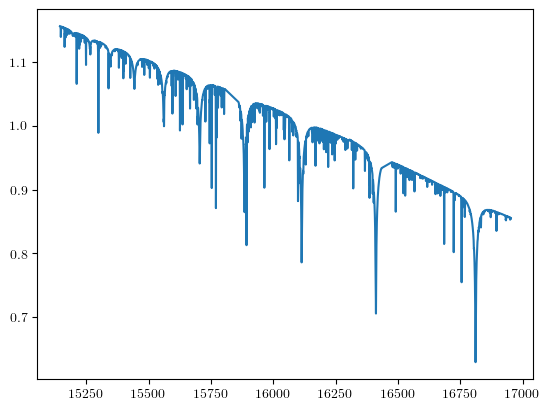

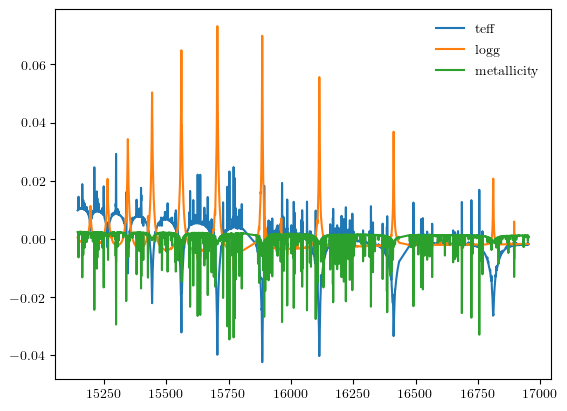

  0.004535 seconds (38.77 k allocations: 666.453 KiB)
  0.013828 seconds (115.79 k allocations: 3.246 MiB)


In [14]:
x = reverse([-1.12, 2.225, 5571.3])
plot(wls, @time interpolate_spectrum(x))

figure()
lines = plot(wls, (@time interpolated_jacobi(x)).* steps')
legend(lines, param_names)
;

## multi-interpolation with a custom type

In [6]:
struct NVec{F, N}
    data :: Vector{F}
end

In [7]:
Base.:+(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .+ y.data)
Base.:-(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .- y.data)

Base.:*(x::NVec{F, N}, y::NVec{F, N}) where F where N = NVec{F, N}(x.data .* y.data)
Base.:*(x::Real, y::NVec{F, N}) where F where N = NVec{F, N}(x .* y.data)
Base.:*(x::NVec{F, N}, y::Real) where F where N = NVec{F, N}(x.data .* y)

Base.:/(x::NVec{F, N}, y::Real) where F where N = NVec{F, N}(x.data ./ y)

Base.zero(::Type{NVec{F, N}}) where F where N = NVec{F, N}(zeros(F, N))

In [81]:
param_inds = CartesianIndices(size(grid)[2:end])
g = [NVec{Float32, size(grid, 1)}(grid[ :, ii]) for ii in param_inds];
itp = CubicSplineInterpolation(tuple(ranges...), g);

In [80]:
@time interpolated_jacobi(x);
@time Interpolations.gradient(itp, x...)
;

  0.011755 seconds (115.79 k allocations: 3.246 MiB)
  0.011010 seconds (1.40 k allocations: 28.294 MiB)


It's slower :(  Perhaps if I could figure out how to tell the compiler that the grid is static get it all into one memory block...

## multi-interpolation with StaticArrays - compile time is prohibitive

In [ ]:
using StaticArrays
g = [SVector{size(grid, 1), Float32}(grid[ :, ii]) for ii in param_inds];
itp = CubicSplineInterpolation(tuple(ranges...), g)

------


# inference - now with derivatives

note: try using autodiff to get the hessian

In [135]:
f = interpolate_spectrum([5112.23, 3.34, 0.112])
err = ones(size(f)) * 0.01
f .+= randn(size(f)) .* err

χ2(params) = sum(((interpolate_spectrum(params) .- f) ./ err).^2)
function χ2grad!(G, params)
    G .= sum( 2 * (interpolate_spectrum(params) .- f) .* interpolated_jacobi(params) ./ err.^2, dims=1)[:]
end
# use gradient
println("no gradient")
@time res = optimize(χ2, llimits, ulimits - steps, [4000., 3., 0.])
println(res.minimizer)

println()
println("gradient")
@time res = optimize(χ2, χ2grad!, llimits, ulimits - steps, [4000., 3., 0.])
println(res.minimizer)
res

no gradient
 25.731803 seconds (208.29 M allocations: 3.727 GiB, 3.53% gc time)
[5114.96252966766, 3.3416138467599836, 0.11231203039363326]

gradient
  1.918047 seconds (24.39 M allocations: 538.542 MiB, 4.56% gc time)
[5114.962529549856, 3.3416138466543974, 0.11231203034744168]


 * Status: success

 * Candidate solution
    Final objective value:     7.694607e+03

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 1.78e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.49e-14 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.76e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   2  (vs limit Inf)
    Iterations:    5
    f(x) calls:    85
    ∇f(x) calls:   85
